In [1]:
!nvidia-smi

Fri Jan 26 04:48:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's

In [3]:
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00


In [4]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (416 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121671 

In [5]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
!mkdir pdfs

In [8]:
!gdown 1NEkg1RruCBYKUZqmj_qmHmCZgvn_zYio -O pdfs/invoice_1.pdf

Downloading...
From: https://drive.google.com/uc?id=1NEkg1RruCBYKUZqmj_qmHmCZgvn_zYio
To: /content/pdfs/invoice_1.pdf
100% 45.3k/45.3k [00:00<00:00, 45.6MB/s]


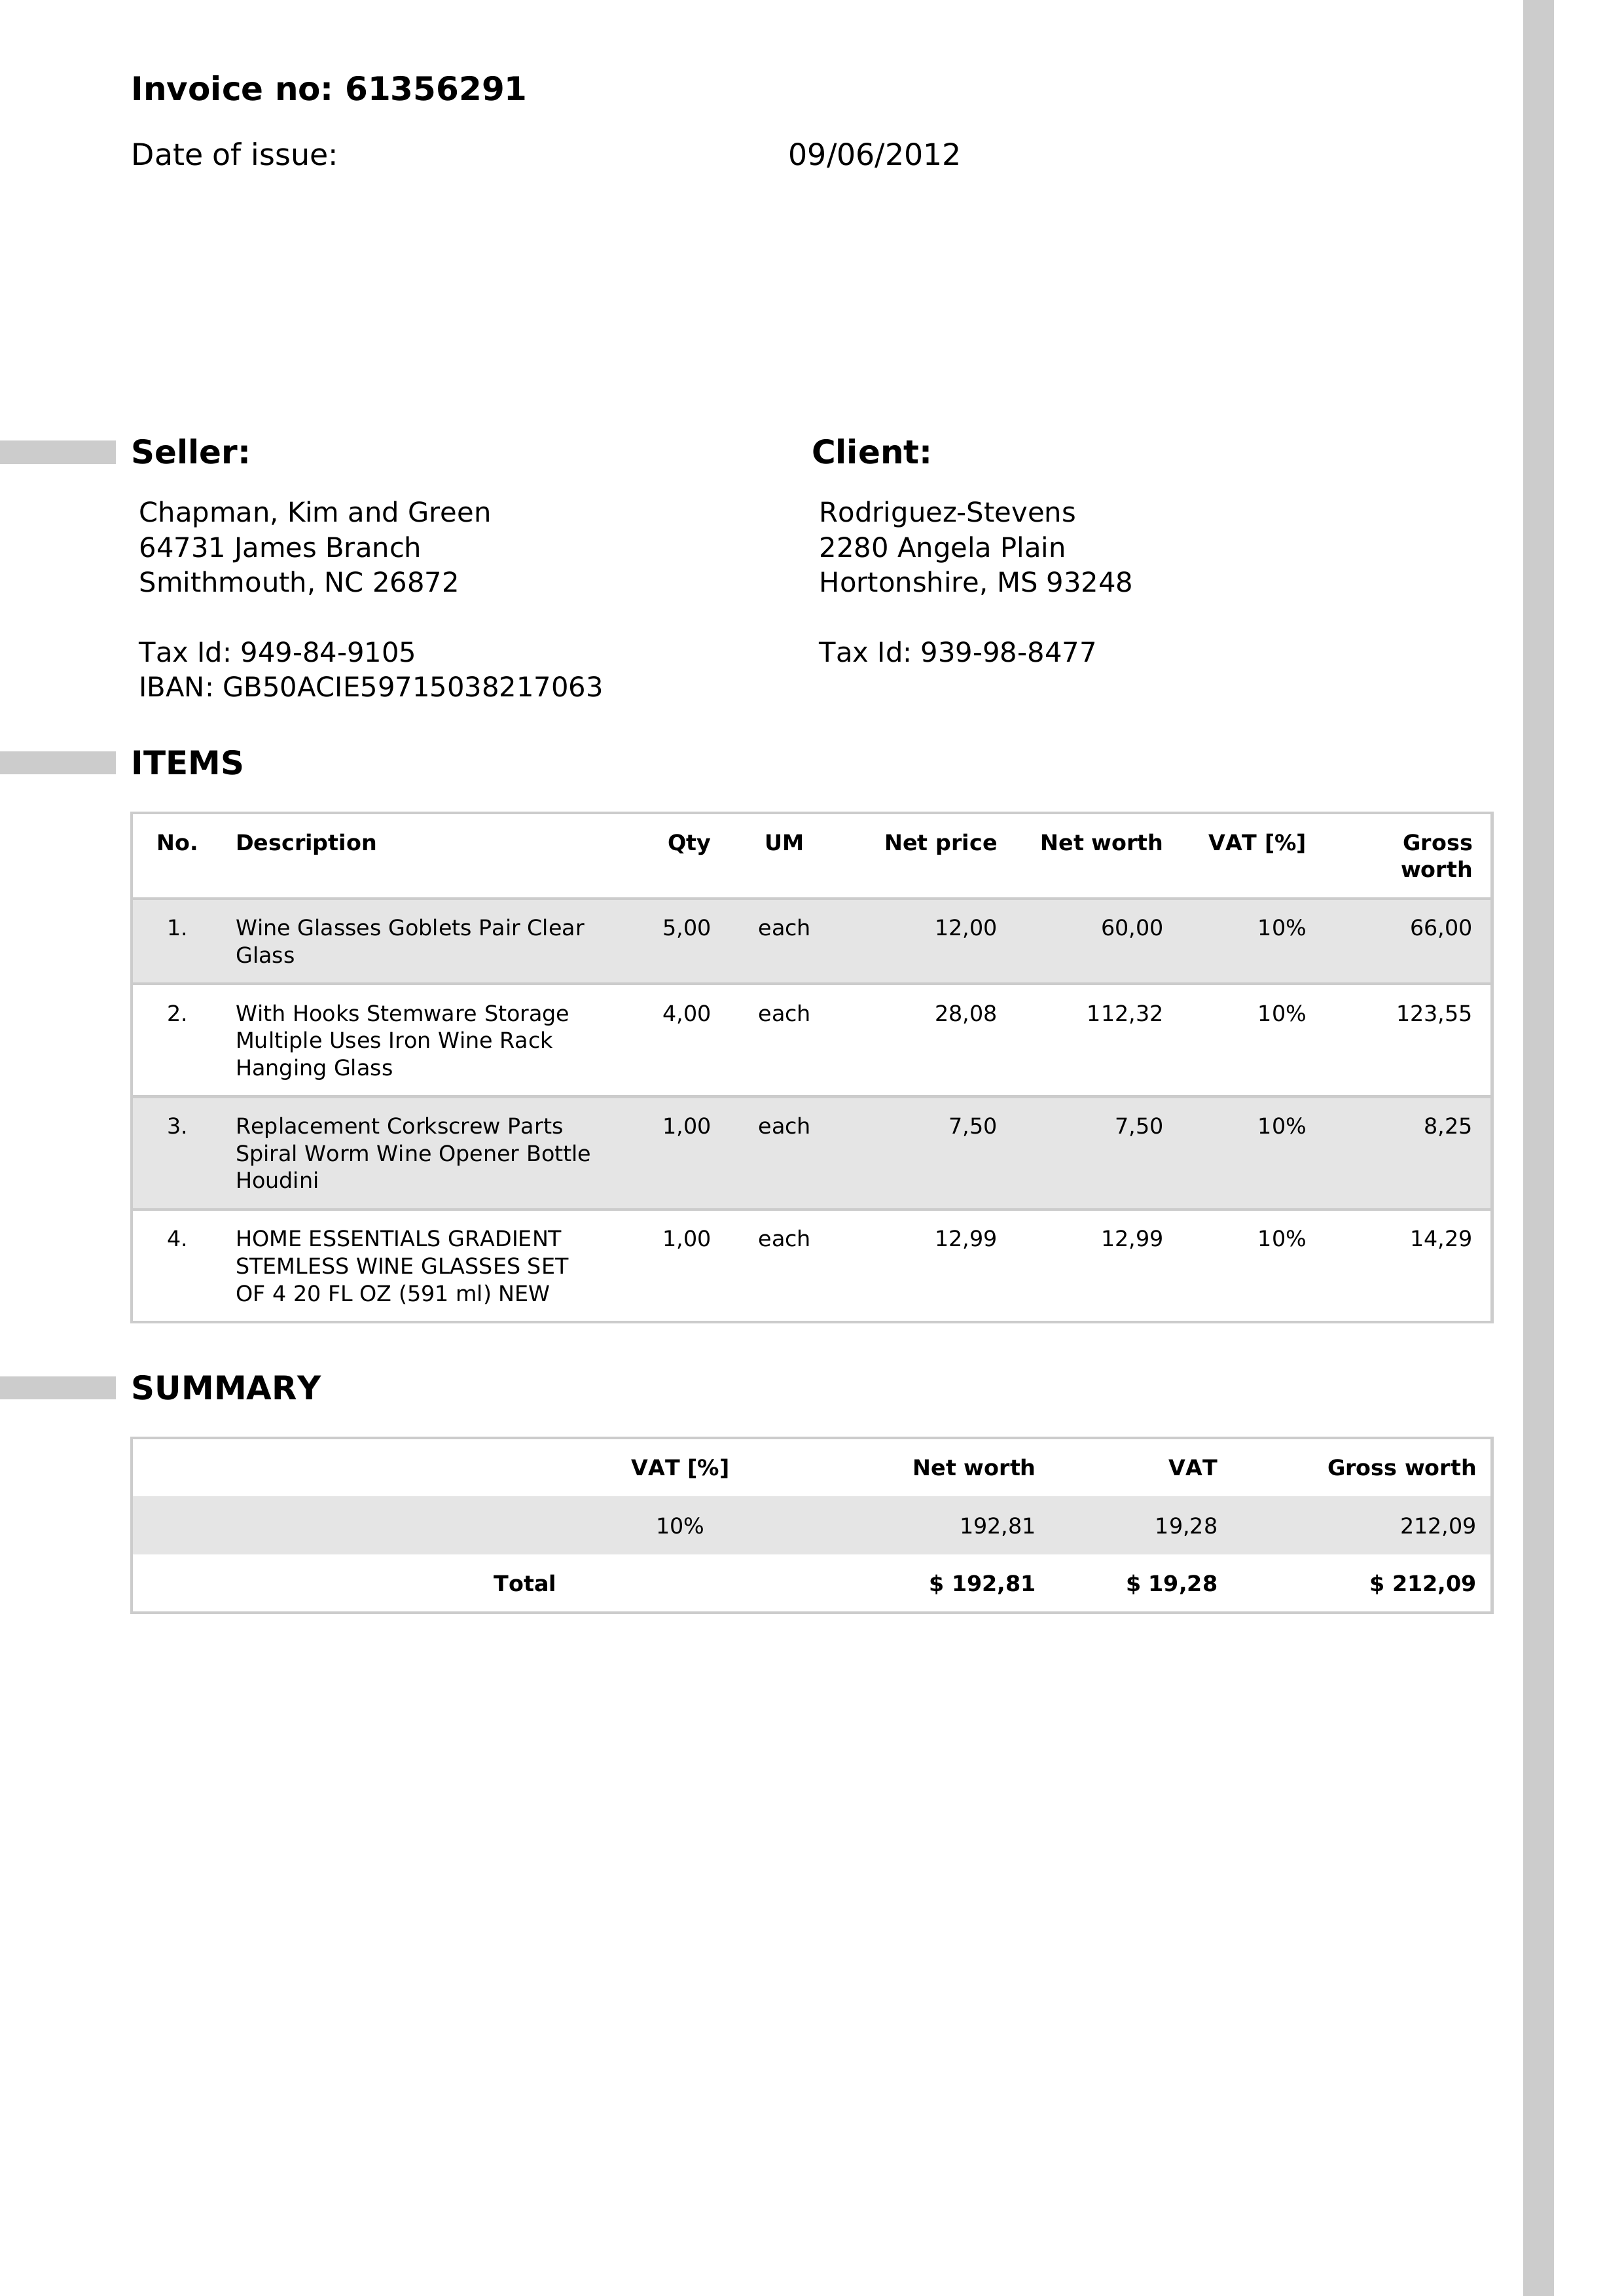

In [9]:
invoice = convert_from_path("pdfs/invoice_1.pdf", dpi=300)
invoice[0]

In [10]:
!rm -rf "db"

In [11]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

1

In [12]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

1

In [14]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 1.44 s, sys: 266 ms, total: 1.71 s
Wall time: 2.18 s


In [15]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [16]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()

In [17]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [18]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [19]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [20]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [21]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [22]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

Start asking questions on the Invoice sample

In [23]:
result = qa_chain("how many invoice items are listed in the invoce?")

 Sure! Based on the information provided, there are 4 invoice items listed in the invoice. These include:

1. Wine Glasses Goblets Pair Clear
2. With Hooks Stemware Storage
3. Replacement Corkscrew Parts
4. HOME ESSENTIALS GRADIENT STEMLESS WINE GLASSES SET OF 4 20 FL OZ (591 ml) NEW


In [24]:
result = qa_chain("please retrieve invoice total gross amount")

 Sure! Based on the provided information, I can help you with your query. The invoice total gross amount is:

$212,09.

To calculate this, we need to add up all the net prices of each item, which are as follows:

$12,00 x 5 = $60,00 (for Wine Glasses Goblets Pair Clear)
$28,08 x 2 = $56,16 (for With Hooks Stemware Storage)
$7,50 x 3 = $22,50 (for Replacement Corkscrew Parts)
$12,99 x 4 = $51,96 (for HOME ESSENTIALS GRADIENT STEMLESS WINE GLASSES SET OF 4)

Adding these amounts together gives us a total gross amount of $212,09.


In [25]:
result = qa_chain("retrieve gross worth for each invoice item line. this is the last column in invoice items table")

 Sure! Based on the provided invoice, here are the gross worth values for each item line:

Item Line Gross Worth

1. Wine Glasses Goblets Pair Clear Glass $66,00
2. With Hooks Stemware Storage Multiple Uses Iron Wine Rack Hanging Glass $123,55
3. Replacement Corkscrew Parts Spiral Worm Wine Opener Bottle Houdini $8,25
4. HOME ESSENTIALS GRADIENT STEMLESS WINE GLASSES SET OF 4 20 FL OZ (591 ml) NEW $14,29


In [26]:
result = qa_chain("what is tax ID for the seller?")

 Sure! Based on the information provided, the tax ID for the seller is:

949-84-9105


In [27]:
result = qa_chain("great, let me know client info")

 Sure! Based on the provided invoice, the client information is:

Name: Rodriguez-Stevens
Address: 2280 Angela Plain, Hortonshire, MS 93248
Tax ID: 939-98-8477


In [28]:
result = qa_chain("please retrieve invoice date")

 Sure! Based on the given information, I can retrieve the invoice date as follows:

The invoice date is: September 6, 2012.

This is based on the "Date of Issue" field, which states that the invoice was issued on 09/06/2012.


In [29]:
result = qa_chain("please retrieve invoice date, and invoice number. im not interested in description, just give me these two values")

 Sure! Based on the provided invoice, here are the two values you requested:

Invoice Date: 09/06/2012

Invoice Number: 61356291
